Using the ivar weighted data with the galaxy mask implemented in angle_calc_1730955668 (from 11/07/24) - checking cuts and generating mock timestream for a set of 264 maps with the beams implemented correctly.

In [177]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from pixell import enmap, enplot, reproject, utils, curvedsky
from tqdm import tqdm
import pandas as pd
import nawrapper as nw
import yaml
import time
import healpy as hp
from scipy import optimize as op
import os

In [2]:
# Loading spectra from run
spectra_dict = np.load('/home/zbh5/act_analysis/act_axion_analysis/results/angle_calc_1730955668/angle_calc_1730955668_spectra.npy',allow_pickle=True).item()

In [26]:
maps = np.array(list(spectra_dict.keys()))
n_maps = len(maps)
print(n_maps)
print(spectra_dict[maps[0]].keys())

264
dict_keys(['ell', 'E1xB2', 'E2xB1', 'E1xE1', 'B2xB2', 'E2xE2', 'B1xB1', 'E1xE2', 'B1xB2', 'E1xB1', 'E2xB2', 'binned_nu', 'estimator', 'covariance', 'CAMB_EE', 'CAMB_BB', 'w2_depth1', 'w2_cross', 'w2_ref', 'meas_angle', 'meas_errbar', 'ivar_sum', 'residual_mean', 'residual_sum', 'map_cut'])


In [4]:
for i in range(n_maps):
    if spectra_dict[maps[i]]['map_cut'] == 1:
        print(i)

43
44
45
229
230
240
241
242


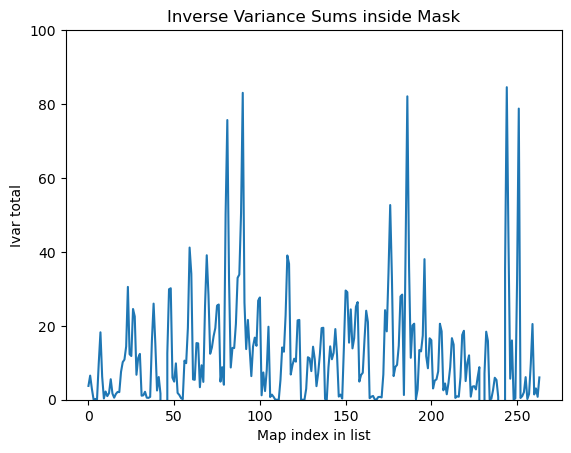

In [102]:
# Investigating trends in ivar_sum
ivar_sums = np.zeros(n_maps)
for i in range(n_maps):
    ivar_sums[i] = spectra_dict[maps[i]]['ivar_sum']
plt.plot(ivar_sums)
plt.ylim(0,100)
plt.title("Inverse Variance Sums inside Mask")
plt.ylabel("Ivar total")
plt.xlabel("Map index in list")
plt.show()
plt.close()

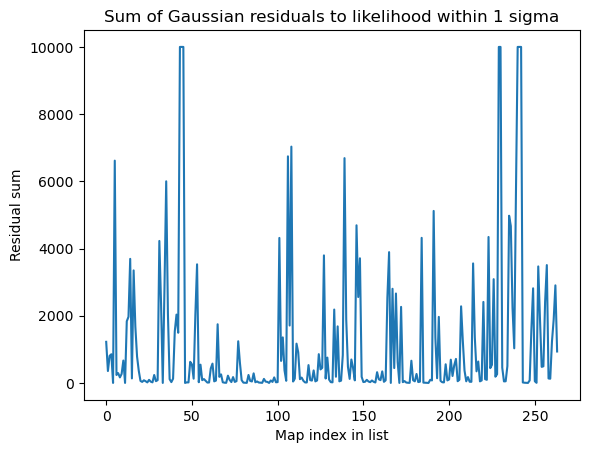

In [120]:
# Investigating trends in residual_sum
residual_sums = np.zeros(n_maps)
for i in range(n_maps):
    residual_sums[i] = np.abs(spectra_dict[maps[i]]['residual_sum'])
plt.plot(residual_sums)
plt.title("Sum of Gaussian residuals to likelihood within 1 sigma")
plt.ylabel("Residual sum")
plt.xlabel("Map index in list")
plt.show()
plt.close()

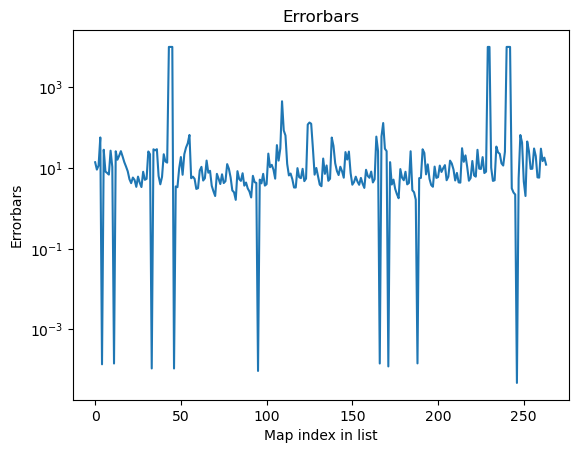

In [49]:
# Using the super small errorbars to identify the failed fits
all_errbars = np.zeros(n_maps)
for i in range(n_maps):
    all_errbars[i] = np.abs(spectra_dict[maps[i]]['meas_errbar'])
plt.semilogy(all_errbars)
plt.title("Errorbars")
plt.ylabel("Errorbars")
plt.xlabel("Map index in list")
plt.show()
plt.close()

In [115]:
print(np.where(all_errbars<0.1)[0])

[  4  11  33  46  95 166 171 188 246]


In [53]:
errbar_good = np.where(all_errbars>0.1)[0]
print(errbar_good)

[  0   1   2   3   5   6   7   8   9  10  12  13  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  32  34  35  36  37  38
  39  40  41  42  43  44  45  47  48  49  50  51  52  53  54  55  56  57
  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75
  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93
  94  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130
 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148
 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 167
 168 169 170 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186
 187 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205
 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223
 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241
 242 243 244 245 247 248 249 250 251 252 253 254 25

In [38]:
ivar_good = np.where(ivar_sums>3.5)[0]
residual_good = np.where(residual_sums<800)[0]
print(ivar_good)
print(residual_good)
print(np.where(residual_sums==9999)[0])

[  0   1   6   7   8  13  19  20  21  22  23  24  25  26  27  28  29  30
  37  38  39  41  46  47  48  49  50  51  56  57  58  59  60  61  62  63
  64  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82
  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100
 102 104 105 112 113 114 115 116 117 118 119 120 121 122 123 128 129 130
 131 132 133 134 135 136 137 140 141 142 143 144 145 149 150 151 152 153
 154 155 156 157 158 159 160 161 162 163 172 173 174 175 176 177 178 179
 180 181 182 183 185 186 187 188 189 190 193 194 195 196 197 198 199 200
 202 203 204 205 206 208 210 211 212 213 217 218 219 220 221 222 224 225
 227 228 231 232 233 237 238 243 244 245 246 247 250 251 255 258 259 263]
[  1   4   6   7   8   9  10  11  15  18  19  20  21  22  23  24  25  26
  27  28  29  30  33  37  38  39  46  47  48  49  50  51  54  55  56  57
  58  59  60  61  62  63  64  66  67  68  69  70  71  72  73  74  75  76
  78  79  80  81  82  83  84  85  86  87  88  89  

In [55]:
all_good_ts = np.intersect1d(np.intersect1d(ivar_good,residual_good),errbar_good)
print(len(all_good_ts))
print(all_good_ts)

161
[  1   6   7   8  19  20  21  22  23  24  25  26  27  28  29  30  37  38
  39  47  48  49  50  51  56  57  58  59  60  61  62  63  64  66  67  68
  69  70  71  72  73  74  75  76  78  79  80  81  82  83  84  85  86  87
  88  89  90  91  92  93  94  96  97  98  99 100 102 104 105 113 114 115
 116 117 118 119 120 121 122 123 128 129 130 131 132 134 136 137 141 142
 143 144 145 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163
 173 174 175 176 177 178 179 180 181 182 183 185 186 187 189 190 193 195
 196 197 198 199 200 202 203 204 205 206 210 211 212 213 217 218 219 221
 222 224 225 227 228 231 232 233 243 244 245 247 250 251 255 258 259]


In [71]:
timestamps = np.array([int(maps[i].split('_')[1]) for i in all_good_ts])
arrays = np.array([maps[i].split('_')[2] for i in all_good_ts])
angles = np.array([spectra_dict[maps[i]]['meas_angle'] for i in all_good_ts])
errbars = np.array([spectra_dict[maps[i]]['meas_errbar'] for i in all_good_ts])
print(timestamps[13:-9])

[1513422389 1513422389 1513422389 1513445778 1513445778 1513445778
 1513481732 1513481732 1513508790 1513515669 1513515669 1513948346
 1513948346 1513997690 1513997690 1513997690 1514027190 1514032657
 1514032657 1514032657 1514085395 1514085395 1514095540 1514095540
 1514095540 1514113590 1514113590 1514113590 1514120675 1514120675
 1514120675 1514157149 1514157149 1514164714 1514164714 1514164714
 1514192734 1514192734 1514192734 1514204984 1514204984 1514204984
 1514243670 1514243670 1514243670 1514277406 1514277406 1514277406
 1514286389 1514286389 1514293005 1514293005 1514293005 1514329590
 1514339718 1514339718 1514426261 1514426261 1514439491 1514439491
 1514439491 1514459190 1514459190 1514459190 1514465335 1514465335
 1514465335 1514549638 1514549638 1514604851 1514604851 1514604851
 1514631990 1514638410 1514638410 1514675189 1514675189 1514686641
 1514686641 1514686641 1514721969 1514721969 1514721969 1514761590
 1514761590 1514761590 1514789181 1514789181 1514789181 151480

Text(0.5, 1.0, 'Sample Timestream')

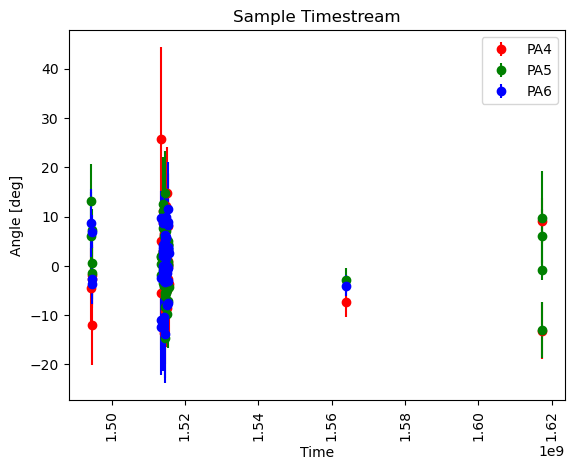

In [63]:
plt.xticks(rotation=90)
plt.errorbar(timestamps[arrays=='pa4'],angles[arrays=='pa4'],yerr=errbars[arrays=='pa4'],fmt='ro',label="PA4")
plt.errorbar(timestamps[arrays=='pa5'],angles[arrays=='pa5'],yerr=errbars[arrays=='pa5'],fmt='go',label="PA5")
plt.errorbar(timestamps[arrays=='pa6'],angles[arrays=='pa6'],yerr=errbars[arrays=='pa6'],fmt='bo',label="PA6")
plt.legend()
plt.xlabel('Time')
plt.ylabel('Angle [deg]')
plt.title('Sample Timestream')
#plt.tight_layout()

Text(0, 0.5, 'Angle [deg]')

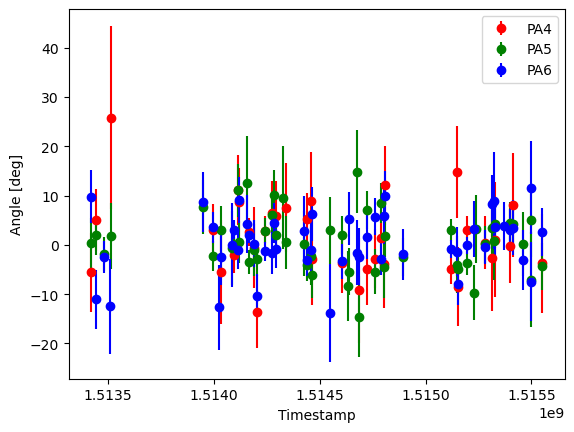

In [79]:
# Plotting only the second bank
plt.xticks(rotation=0)
plt.errorbar(timestamps[13:-9][arrays[13:-9]=='pa4'],angles[13:-9][arrays[13:-9]=='pa4'],yerr=errbars[13:-9][arrays[13:-9]=='pa4'],fmt='ro',label="PA4")
plt.errorbar(timestamps[13:-9][arrays[13:-9]=='pa5'],angles[13:-9][arrays[13:-9]=='pa5'],yerr=errbars[13:-9][arrays[13:-9]=='pa5'],fmt='go',label="PA5")
plt.errorbar(timestamps[13:-9][arrays[13:-9]=='pa6'],angles[13:-9][arrays[13:-9]=='pa6'],yerr=errbars[13:-9][arrays[13:-9]=='pa6'],fmt='bo',label="PA6")
plt.legend()
plt.xlabel('Timestamp')
plt.ylabel('Angle [deg]')
#plt.title('Angles from Three Weeks of Depth-1 Maps')
#plt.tight_layout()

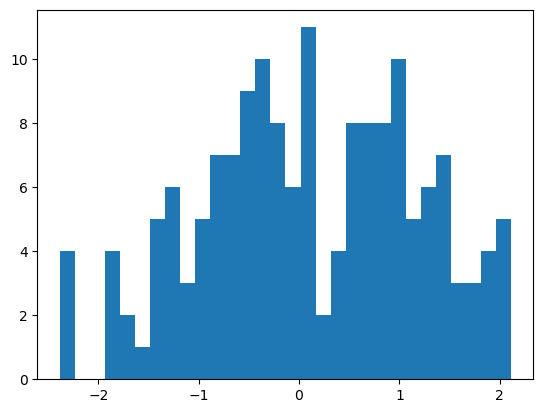

In [88]:
plt.hist(angles/errbars, bins=30)
plt.show()
plt.close()

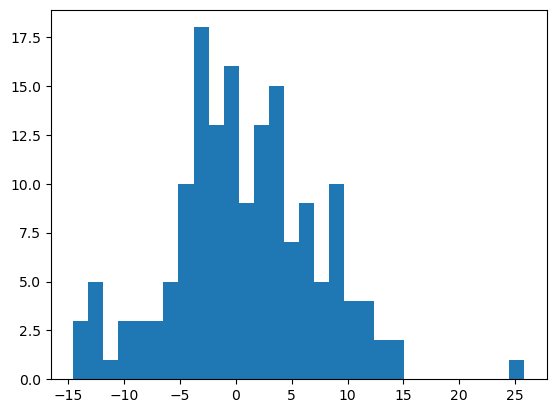

In [87]:
plt.hist(angles, bins=30)
plt.show()
plt.close()

In [84]:
print(np.where(errbars==np.min(errbars[13:-9])))

(array([48]),)


In [98]:
maps[248]

'depth1_1617322173_pa4_f150_map.fits'

139 28 22 58 8 9
260
13.100000000000003
0.40718562874251496
1.0


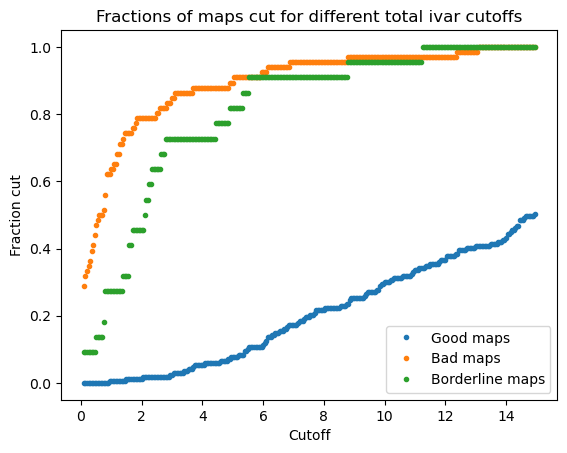

In [229]:
# Iterating over different cutoffs to examine fraction that is cut
# List of indices from looking at likelihoods by eye
very_good = [20,21,22,23,24,25,26,27,28,29,30,37,38,39,47,48,51,56,57,58,59,60,63,64,66,67,68,69,70,71,72,
             73,74,75,76,79,80,81,82,83,84,85,87,88,89,90,91,92,93,94,96,97,98,99,100,105,113,114,115,116,117,
             119,120,121,122,123,128,130,131,132,134,136,137,142,145,149,150,151,152,153,154,155,156,157,158,159,
             160,161,162,163,173,174,175,176,177,179,180,181,182,183,185,186,187,189,190,193,195,196,197,198,
             199,200,201,202,203,204,205,206,210,211,212,213,218,219,221,222,227,228,231,232,233,243,244,245,
             247,250,251,258,259]
good = [0,1,2,6,7,8,19,49,61,62,65,86,102,104,112,118,141,143,144,178,209,215,217,224,225,254,255,263]
borderline = [5,10,13,14,16,17,18,35,77,78,103,106,107,108,129,139,208,226,236,238,239,257]
bad = [3,9,12,15,31,32,34,36,40,41,42,50,52,53,54,55,101,109,110,111,124,125,126,127,133,
       135,138,140,146,147,148,164,165,167,168,169,170,172,184,191,192,194,207,214,216,220,
       223,234,235,237,248,249,252,253,256,260,261,262]
cut = [43,44,45,229,230,240,241,242]
bad_fits = [4,11,33,46,95,166,171,188,246] # all bad ones because curve_fit fails to fit
print(len(very_good), len(good), len(borderline), len(bad), len(cut), len(bad_fits))
all_good = np.sort(very_good+good)
all_bad = np.sort(bad+cut)

good_fractions_cut = []
bad_fractions_cut = []
border_fractions_cut = []
bad_fits_cut = []
cutoffs = np.arange(0.1,15.0,0.05)
for cutoff in cutoffs:
    in_good = 0
    in_bad = 0
    in_border = 0
    in_bad_fits = 0
    outlier_indices_ivar_sums = np.where(ivar_sums < cutoff)[0]
    #print(outlier_indices_ivar_sums)
    num_outlier = len(outlier_indices_ivar_sums)
    for i in range(num_outlier):
        if outlier_indices_ivar_sums[i] in all_good: in_good += 1
        elif outlier_indices_ivar_sums[i] in all_bad: in_bad += 1
        elif outlier_indices_ivar_sums[i] in borderline: in_border += 1
        elif outlier_indices_ivar_sums[i] in bad_fits: in_bad_fits += 1
        else: print("index " + str(i) + " not in any list")
    good_fractions_cut.append(in_good/len(all_good))
    bad_fractions_cut.append(in_bad/len(all_bad))
    border_fractions_cut.append(in_border/len(borderline))

bad_fractions_cut = np.array(bad_fractions_cut)
# Finding the index at which all the bad maps are cut
index_all_bad_cut = np.where(bad_fractions_cut == 1.0)[0][0]
print(index_all_bad_cut)
print(cutoffs[index_all_bad_cut])
print(good_fractions_cut[index_all_bad_cut])
print(border_fractions_cut[index_all_bad_cut])
    
plt.plot(cutoffs, good_fractions_cut, '.', label="Good maps")
plt.plot(cutoffs, bad_fractions_cut, '.', label="Bad maps")
plt.plot(cutoffs, border_fractions_cut, '.', label="Borderline maps")
plt.legend()
plt.title("Fractions of maps cut for different total ivar cutoffs")
plt.xlabel("Cutoff")
plt.ylabel("Fraction cut")
plt.show()
plt.close()

596
20
Fraction of good maps cut at index with all bad cut:  0.8083832335329342
Fraction borderline cut at index with all bad cut:  1.0


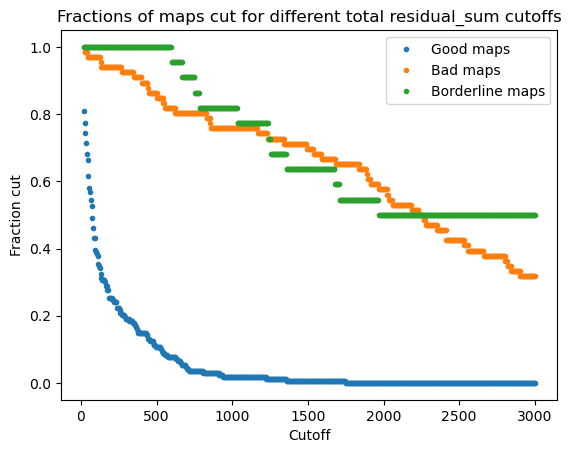

In [127]:
# Iterating over different cutoffs of residual_sums to examine fraction that is cut
# List of indices from looking at likelihoods by eye
good_fractions_cut = []
bad_fractions_cut = []
border_fractions_cut = []
bad_fits_cut = []
cutoffs = np.arange(3000,15,-5) # Want to cut big values
for cutoff in cutoffs:
    in_good = 0
    in_bad = 0
    in_border = 0
    in_bad_fits = 0
    outlier_indices_residual_sums = np.where(residual_sums > cutoff)[0]
    #print(outlier_indices_residual_sums)
    num_outlier = len(outlier_indices_residual_sums)
    for i in range(num_outlier):
        if outlier_indices_residual_sums[i] in all_good: in_good += 1
        elif outlier_indices_residual_sums[i] in all_bad: in_bad += 1
        elif outlier_indices_residual_sums[i] in borderline: in_border += 1
        elif outlier_indices_ivar_sums[i] in bad_fits: in_bad_fits += 1
        else: print("index " + str(i) + " not in any list")
    good_fractions_cut.append(in_good/len(all_good))
    bad_fractions_cut.append(in_bad/len(all_bad))
    border_fractions_cut.append(in_border/len(borderline))

bad_fractions_cut = np.array(bad_fractions_cut)
# Finding the index at which all the bad maps are cut
index_all_bad_cut = np.where(bad_fractions_cut == 1.0)[0][0]
print(index_all_bad_cut)
print(cutoffs[index_all_bad_cut])
print("Fraction of good maps cut at index with all bad cut: ", good_fractions_cut[index_all_bad_cut])
print("Fraction borderline cut at index with all bad cut: ", border_fractions_cut[index_all_bad_cut])
    
plt.plot(cutoffs, good_fractions_cut, '.', label="Good maps")
plt.plot(cutoffs, bad_fractions_cut, '.', label="Bad maps")
plt.plot(cutoffs, border_fractions_cut, '.', label="Borderline maps")
plt.legend()
plt.title("Fractions of maps cut for different total residual_sum cutoffs")
plt.xlabel("Cutoff")
plt.ylabel("Fraction cut")
plt.show()
plt.close()

In [126]:
# It seems there are always some bad maps that have good residual_sum values
print(np.sort(residual_sums[all_bad]))

[  21.18327086   41.41004804  129.06303549  134.08070861  268.7361099
  345.68136101  401.75040358  442.22904647  447.97027477  502.60770335
  542.75305865  552.26646095  620.24942511  828.47022933  853.62511699
  855.86662001 1168.84085411 1232.37115066 1344.17083412 1492.8449718
 1536.1137571  1589.45005791 1682.83249105 1835.26473168 1886.6388479
 1891.5178084  1911.09271278 1965.13820737 2021.07499328 2033.46287009
 2059.99871254 2183.33593621 2232.14325177 2263.21442736 2279.25766446
 2352.62439274 2410.121003   2412.34345233 2534.70215539 2556.55737769
 2660.95375514 2801.65589512 2815.31727573 2842.22816874 2903.50537866
 3466.8437293  3529.44743848 3556.16096866 3708.89906937 3795.45993165
 3892.13285385 4224.81906565 4314.85852259 4317.36185388 4343.12423658
 4690.65544462 4974.98879102 5118.1250513  9999.         9999.
 9999.         9999.         9999.         9999.         9999.
 9999.        ]


In [159]:
# Trying the same thing but with both the residual_sum and ivar_sum cuts simultaneously
# For the quick test that I did for Steve above, I used residual_cutoff = 800 and ivar_cutoff = 3.5
residual_cutoffs = np.arange(3000,15,-5) # Want to cut big values
ivar_cutoffs = np.arange(0.1,15.0,0.05)
good_fractions_cut = np.zeros((residual_cutoffs.size, ivar_cutoffs.size))
bad_fractions_cut = np.zeros((residual_cutoffs.size, ivar_cutoffs.size))
border_fractions_cut = np.zeros((residual_cutoffs.size, ivar_cutoffs.size))
bad_fits_cut = np.zeros((residual_cutoffs.size, ivar_cutoffs.size))
for i in range(residual_cutoffs.size):
    for j in range(ivar_cutoffs.size):
        in_good = 0
        in_bad = 0
        in_border = 0
        in_bad_fits = 0
        outlier_indices_residual_sums = np.where(residual_sums > residual_cutoffs[i])[0]
        outlier_indices_ivar_sums = np.where(ivar_sums < ivar_cutoffs[j])[0]
        # We want all maps that are cut by either cut
        outlier_union = np.union1d(outlier_indices_residual_sums,outlier_indices_ivar_sums)
        num_outlier = len(outlier_union)
        #print(num_outlier)
        for i in range(num_outlier):
            if outlier_union[i] in all_good: in_good += 1
            elif outlier_union[i] in all_bad: in_bad += 1
            elif outlier_union[i] in borderline: in_border += 1
            elif outlier_union[i] in bad_fits: in_bad_fits += 1
            else: print("index " + str(i) + " not in any list")
        good_fractions_cut[i,j] = in_good/len(all_good)
        bad_fractions_cut[i,j] = in_bad/len(all_bad)
        border_fractions_cut[i,j] = in_border/len(borderline)

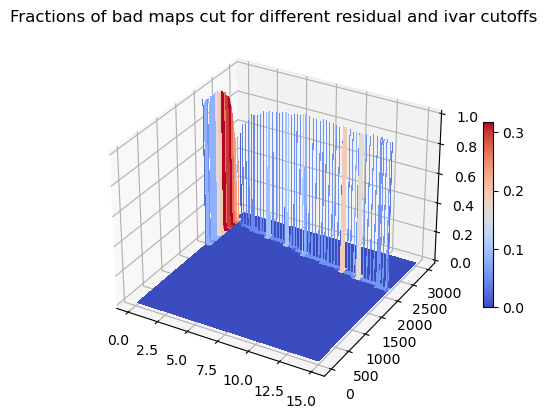

In [160]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
X, Y = np.meshgrid(ivar_cutoffs,residual_cutoffs)
surf = ax.plot_surface(X, Y, bad_fractions_cut, cmap=cm.coolwarm, linewidth=0,antialiased=False)
#plt.plot(cutoffs, good_fractions_cut, '.', label="Good maps")
#plt.plot(cutoffs, bad_fractions_cut, '.', label="Bad maps")
#plt.plot(cutoffs, border_fractions_cut, '.', label="Borderline maps")
#plt.legend()
ax.set_zlim(0.0,1.0)
fig.colorbar(surf, shrink=0.5)
plt.title("Fractions of bad maps cut for different residual and ivar cutoffs")
#plt.xlabel("Cutoff")
#plt.ylabel("Fraction cut")
plt.show()
plt.close()

In [142]:
print(X[0][1], Y[0][1])

0.15000000000000002 3000


96
4.900000000000001
Fraction of good maps cut at index with all bad cut:  0.0718562874251497
Fraction borderline cut at index with all bad cut:  0.8636363636363636


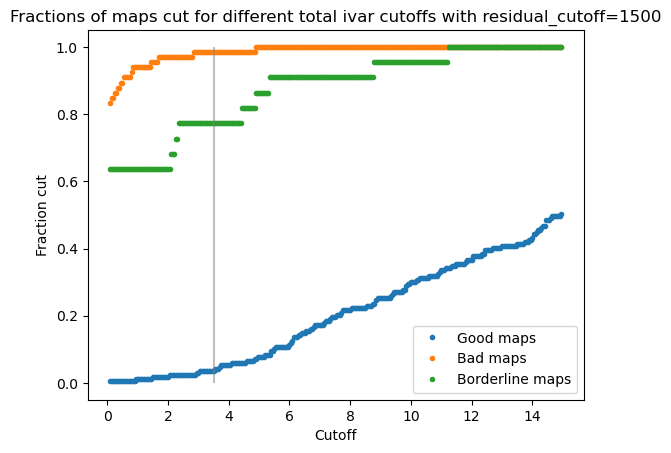

In [167]:
# Visualizing 2D slice with variable ivar_cutoff and residual_cutoff fixed
good_fractions_cut = []
bad_fractions_cut = []
border_fractions_cut = []
bad_fits_cut = []
residual_cutoff = 1500
cutoffs = np.arange(0.1,15.0,0.05)
for cutoff in cutoffs:
    in_good = 0
    in_bad = 0
    in_border = 0
    in_bad_fits = 0
    outlier_indices_ivar_sums = np.where(ivar_sums < cutoff)[0]
    outlier_indices_residual_sums = np.where(residual_sums > residual_cutoff)[0]
    #print(outlier_indices_ivar_sums)
    outlier_union = np.union1d(outlier_indices_residual_sums,outlier_indices_ivar_sums)
    num_outlier = len(outlier_union)
    for i in range(num_outlier):
        if outlier_union[i] in all_good: in_good += 1
        elif outlier_union[i] in all_bad: in_bad += 1
        elif outlier_union[i] in borderline: in_border += 1
        elif outlier_union[i] in bad_fits: in_bad_fits += 1
        else: print("index " + str(i) + " not in any list")
    good_fractions_cut.append(in_good/len(all_good))
    bad_fractions_cut.append(in_bad/len(all_bad))
    border_fractions_cut.append(in_border/len(borderline))

bad_fractions_cut = np.array(bad_fractions_cut)
# Finding the index at which all the bad maps are cut
index_all_bad_cut = np.where(bad_fractions_cut == 1.0)[0][0]
print(index_all_bad_cut)
print(cutoffs[index_all_bad_cut])
print("Fraction of good maps cut at index with all bad cut: ", good_fractions_cut[index_all_bad_cut])
print("Fraction borderline cut at index with all bad cut: ", border_fractions_cut[index_all_bad_cut])
    
plt.plot(cutoffs, good_fractions_cut, '.', label="Good maps")
plt.plot(cutoffs, bad_fractions_cut, '.', label="Bad maps")
plt.plot(cutoffs, border_fractions_cut, '.', label="Borderline maps")
plt.vlines(3.5, 0.0, 1.0, colors='gray',alpha=0.5) # Used 3.5 for cut in timestream plot above
plt.legend()
plt.title("Fractions of maps cut for different total ivar cutoffs with residual_cutoff="+str(residual_cutoff))
plt.xlabel("Cutoff")
plt.ylabel("Fraction cut")
plt.show()
plt.close()

96
4.900000000000001
Fraction of good maps cut at index with all bad cut:  0.08383233532934131
Fraction borderline cut at index with all bad cut:  0.9090909090909091


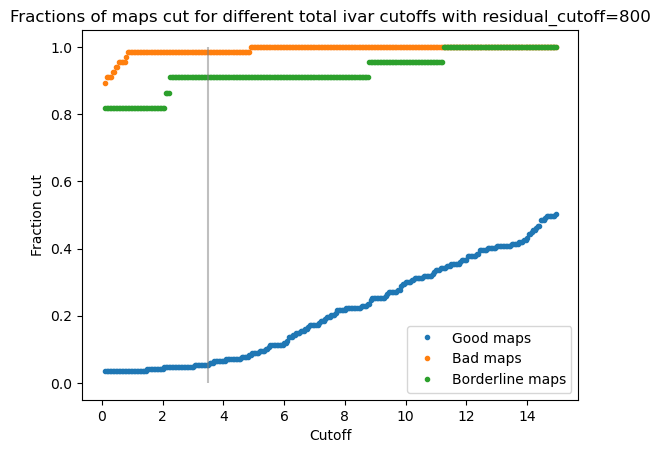

In [168]:
# residual_cutoff=800 like in the plot for Steve
good_fractions_cut = []
bad_fractions_cut = []
border_fractions_cut = []
bad_fits_cut = []
residual_cutoff = 800
cutoffs = np.arange(0.1,15.0,0.05)
for cutoff in cutoffs:
    in_good = 0
    in_bad = 0
    in_border = 0
    in_bad_fits = 0
    outlier_indices_ivar_sums = np.where(ivar_sums < cutoff)[0]
    outlier_indices_residual_sums = np.where(residual_sums > residual_cutoff)[0]
    #print(outlier_indices_ivar_sums)
    outlier_union = np.union1d(outlier_indices_residual_sums,outlier_indices_ivar_sums)
    num_outlier = len(outlier_union)
    for i in range(num_outlier):
        if outlier_union[i] in all_good: in_good += 1
        elif outlier_union[i] in all_bad: in_bad += 1
        elif outlier_union[i] in borderline: in_border += 1
        elif outlier_union[i] in bad_fits: in_bad_fits += 1
        else: print("index " + str(i) + " not in any list")
    good_fractions_cut.append(in_good/len(all_good))
    bad_fractions_cut.append(in_bad/len(all_bad))
    border_fractions_cut.append(in_border/len(borderline))

bad_fractions_cut = np.array(bad_fractions_cut)
# Finding the index at which all the bad maps are cut
index_all_bad_cut = np.where(bad_fractions_cut == 1.0)[0][0]
print(index_all_bad_cut)
print(cutoffs[index_all_bad_cut])
print("Fraction of good maps cut at index with all bad cut: ", good_fractions_cut[index_all_bad_cut])
print("Fraction borderline cut at index with all bad cut: ", border_fractions_cut[index_all_bad_cut])
    
plt.plot(cutoffs, good_fractions_cut, '.', label="Good maps")
plt.plot(cutoffs, bad_fractions_cut, '.', label="Bad maps")
plt.plot(cutoffs, border_fractions_cut, '.', label="Borderline maps")
plt.vlines(3.5, 0.0, 1.0, colors='gray',alpha=0.5) # Used 3.5 for cut in timestream plot above
plt.legend()
plt.title("Fractions of maps cut for different total ivar cutoffs with residual_cutoff="+str(residual_cutoff))
plt.xlabel("Cutoff")
plt.ylabel("Fraction cut")
plt.show()
plt.close()

15
0.8500000000000002
Fraction of good maps cut at index with all bad cut:  0.10778443113772455
Fraction borderline cut at index with all bad cut:  1.0


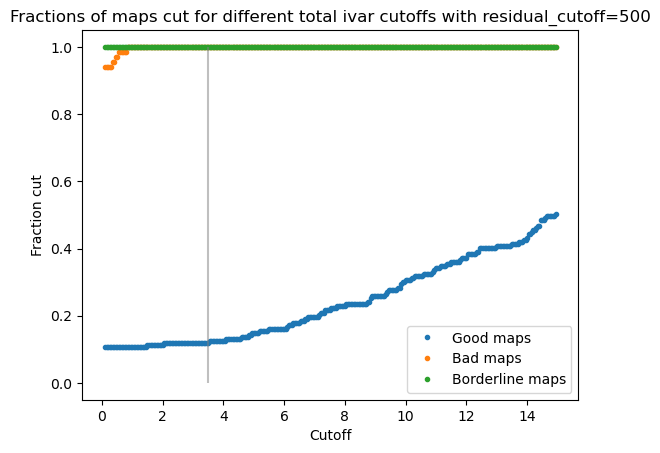

In [172]:
# residual_cutoff=500 just to see what happens - should cut more of the good maps
good_fractions_cut = []
bad_fractions_cut = []
border_fractions_cut = []
bad_fits_cut = []
residual_cutoff = 500
cutoffs = np.arange(0.1,15.0,0.05)
for cutoff in cutoffs:
    in_good = 0
    in_bad = 0
    in_border = 0
    in_bad_fits = 0
    outlier_indices_ivar_sums = np.where(ivar_sums < cutoff)[0]
    outlier_indices_residual_sums = np.where(residual_sums > residual_cutoff)[0]
    #print(outlier_indices_ivar_sums)
    outlier_union = np.union1d(outlier_indices_residual_sums,outlier_indices_ivar_sums)
    num_outlier = len(outlier_union)
    for i in range(num_outlier):
        if outlier_union[i] in all_good: in_good += 1
        elif outlier_union[i] in all_bad: in_bad += 1
        elif outlier_union[i] in borderline: in_border += 1
        elif outlier_union[i] in bad_fits: in_bad_fits += 1
        else: print("index " + str(i) + " not in any list")
    good_fractions_cut.append(in_good/len(all_good))
    bad_fractions_cut.append(in_bad/len(all_bad))
    border_fractions_cut.append(in_border/len(borderline))

bad_fractions_cut = np.array(bad_fractions_cut)
# Finding the index at which all the bad maps are cut
index_all_bad_cut = np.where(bad_fractions_cut == 1.0)[0][0]
print(index_all_bad_cut)
print(cutoffs[index_all_bad_cut])
print("Fraction of good maps cut at index with all bad cut: ", good_fractions_cut[index_all_bad_cut])
print("Fraction borderline cut at index with all bad cut: ", border_fractions_cut[index_all_bad_cut])
    
plt.plot(cutoffs, good_fractions_cut, '.', label="Good maps")
plt.plot(cutoffs, bad_fractions_cut, '.', label="Bad maps")
plt.plot(cutoffs, border_fractions_cut, '.', label="Borderline maps")
plt.vlines(3.5, 0.0, 1.0, colors='gray',alpha=0.5) # Used 3.5 for cut in timestream plot above
plt.legend()
plt.title("Fractions of maps cut for different total ivar cutoffs with residual_cutoff="+str(residual_cutoff))
plt.xlabel("Cutoff")
plt.ylabel("Fraction cut")
plt.show()
plt.close()

The residual sums are not completely correct for this data set since I left out the absolute value before adding them. That would help avoid washout effects that make it harder to distinguish bad fits from good fits. I am going to recalculate the sums here from the spectra (which involves recalculating the likelihood) so that I can ensure that the values I am using for the cutoffs are realistic.

In [173]:
def estimator_likelihood(angle, estimator, covariance, ClEE):
    """For a given difference in angle between the depth-1 map (map 1) and the coadd (map 2),
       returns the value of the normalized likelihood for our estimator.
       
       ClEE is the theory EE spectrum from CAMB"""

    numerator = (estimator - ClEE*np.sin(2*angle))**2
    denominator = 2*covariance
    likelihood = np.exp(-np.sum(numerator/denominator))
    return likelihood

def gaussian(x,mean,sigma):
    """Normalized Gaussian for curve_fit"""
    amp = 1.0
    return amp*np.exp(-(x-mean)**2/(2*sigma**2))

def gaussian_fit_curvefit(angles,data):
    """
        Uses scipy.optimize.curve_fit() to fit a Gaussian to the likelihood to
        get the mean and standard deviation.

        Assumes everything is in radians.
    """
    guess = [1.0*np.pi/180.0, 5.0*np.pi/180.0] # Mean=1, stddev=5 worked well for 73 test maps
    popt, pcov = op.curve_fit(gaussian,angles,data,guess,maxfev=50000)
    mean = popt[0]
    std_dev = np.abs(popt[1])
    return mean, std_dev

def sample_likelihood_and_fit(estimator,covariance,theory_ClEE,angle_min_deg=-20.0,angle_max_deg=20.0,
                              num_pts=10000,use_curvefit=True,plot_like=False,output_dir=None,map_fname=None):
    """
       Samples likelihood for a range of angles and returns the best fit for the
       mean and std dev of the resulting Gaussian in degrees.  
       Has the option to do the fitting with scipy.optimize.curve_fit() (set use_curvefit=True)
       or a method using moments of the Gaussian. The moments method is faster but less
       accurate when the likelihood deviates from Gaussianity in any way.
    """
    if(angle_min_deg >= angle_max_deg): 
        raise ValueError("The min angle must be smaller than the max!")
    angles_deg = np.linspace(angle_min_deg,angle_max_deg,num=num_pts)
    angles_rad = np.deg2rad(angles_deg)
    
    bin_sampled_likelihood = [estimator_likelihood(angle,estimator,covariance,theory_ClEE) for angle in angles_rad]
    norm_sampled_likelihood = bin_sampled_likelihood/np.max(bin_sampled_likelihood)
    
    if use_curvefit:
        fit_values = gaussian_fit_curvefit(angles_rad,norm_sampled_likelihood)
        fit_values_deg = [np.rad2deg(fit_values[0]), np.rad2deg(fit_values[1])]
        # Could add some flag or option to redo the fit for a given map if curve_fit() returns
        # a bad stddev value from failing to fit - for now I will leave it so I can see easily by the stddev that it fails
    else:
        fit_values = gaussian_fit_moment(angles_rad,norm_sampled_likelihood)
        fit_values_deg = [np.rad2deg(fit_values[0]), np.rad2deg(fit_values[1])]

    # Calculating mean and sum of abs of residual between likelihood and best fit Gaussian
    # within 1 sigma of mean value - two possible ways of identifying and cutting poor S/N or bad fits
    residual = norm_sampled_likelihood - gaussian(angles_rad,fit_values[0],fit_values[1])
    minus_sigma_idx = np.searchsorted(angles_rad, fit_values[0]-fit_values[1])
    plus_sigma_idx = np.searchsorted(angles_rad, fit_values[0]+fit_values[1])
    residual_mean = np.mean(residual[minus_sigma_idx:plus_sigma_idx])
    residual_sum = np.sum(np.abs(residual[minus_sigma_idx:plus_sigma_idx]))

    if plot_like:
        map_name = os.path.split(map_fname)[1][:-9] # removing "_map.fits"
        plot_likelihood(output_dir, map_name, angles_deg, norm_sampled_likelihood,fit_values_deg,residual)

    return fit_values_deg, residual_mean, residual_sum

In [182]:
test_CAMB_EE = spectra_dict[maps[0]]['CAMB_EE']
residual_sums_corr = 9999*np.ones(n_maps)
residual_means_corr = 9999*np.ones(n_maps)

map_nums = np.arange(n_maps)
for map_num in map_nums:
    if spectra_dict[maps[map_num]]['map_cut'] != 1:
        results,res_mean,res_sum = sample_likelihood_and_fit(spectra_dict[maps[map_num]]['estimator'],
                                                     spectra_dict[maps[map_num]]['covariance'],
                                                     test_CAMB_EE,angle_min_deg=-50.0,
                                    angle_max_deg=50.0,num_pts=200000,plot_like=False,map_fname='map '+str(map_num))
        residual_sums_corr[map_num] = res_sum
        residual_means_corr[map_num] = res_mean

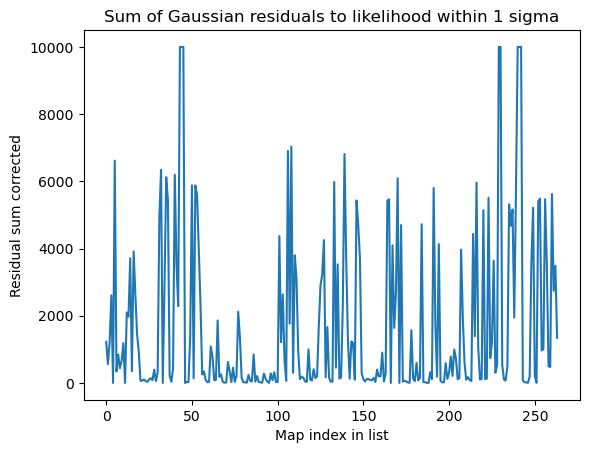

In [183]:
# Investigating trends in residual_sum_corr
plt.plot(residual_sums_corr)
plt.title("Sum of Gaussian residuals to likelihood within 1 sigma")
plt.ylabel("Residual sum corrected")
plt.xlabel("Map index in list")
plt.show()
plt.close()

540
300
Fraction of good maps cut at index with all bad cut:  0.30538922155688625
Fraction borderline cut at index with all bad cut:  1.0


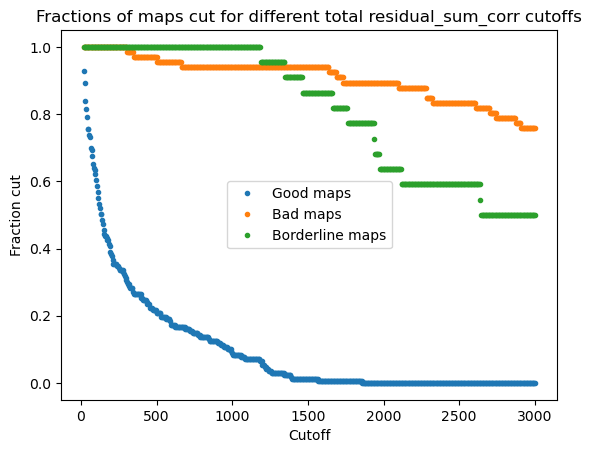

In [184]:
# Rerunning cuts for residual_sums_corr alone
# Iterating over different cutoffs of residual_sums to examine fraction that is cut
# List of indices from looking at likelihoods by eye
good_fractions_cut = []
bad_fractions_cut = []
border_fractions_cut = []
bad_fits_cut = []
cutoffs = np.arange(3000,15,-5) # Want to cut big values
for cutoff in cutoffs:
    in_good = 0
    in_bad = 0
    in_border = 0
    in_bad_fits = 0
    outlier_indices_residual_sums = np.where(residual_sums_corr > cutoff)[0]
    #print(outlier_indices_residual_sums)
    num_outlier = len(outlier_indices_residual_sums)
    for i in range(num_outlier):
        if outlier_indices_residual_sums[i] in all_good: in_good += 1
        elif outlier_indices_residual_sums[i] in all_bad: in_bad += 1
        elif outlier_indices_residual_sums[i] in borderline: in_border += 1
        elif outlier_indices_ivar_sums[i] in bad_fits: in_bad_fits += 1
        else: print("index " + str(i) + " not in any list")
    good_fractions_cut.append(in_good/len(all_good))
    bad_fractions_cut.append(in_bad/len(all_bad))
    border_fractions_cut.append(in_border/len(borderline))

bad_fractions_cut = np.array(bad_fractions_cut)
# Finding the index at which all the bad maps are cut
index_all_bad_cut = np.where(bad_fractions_cut == 1.0)[0][0]
print(index_all_bad_cut)
print(cutoffs[index_all_bad_cut])
print("Fraction of good maps cut at index with all bad cut: ", good_fractions_cut[index_all_bad_cut])
print("Fraction borderline cut at index with all bad cut: ", border_fractions_cut[index_all_bad_cut])
    
plt.plot(cutoffs, good_fractions_cut, '.', label="Good maps")
plt.plot(cutoffs, bad_fractions_cut, '.', label="Bad maps")
plt.plot(cutoffs, border_fractions_cut, '.', label="Borderline maps")
plt.legend()
plt.title("Fractions of maps cut for different total residual_sum_corr cutoffs")
plt.xlabel("Cutoff")
plt.ylabel("Fraction cut")
plt.show()
plt.close()

9
0.5500000000000002
Fraction of good maps cut at index with all bad cut:  0.011976047904191617
Fraction borderline cut at index with all bad cut:  0.8636363636363636


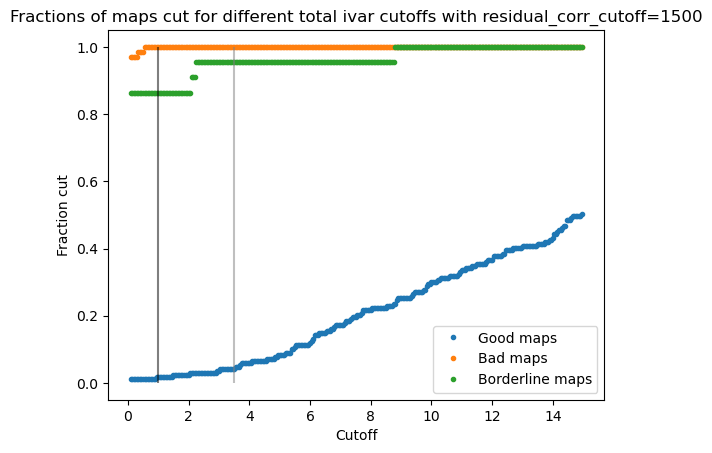

In [239]:
# Using residual_sums_corr and cutoff of 1500 along with ivar_sums
# Visualizing 2D slice with variable ivar_cutoff and residual_cutoff fixed
good_fractions_cut = []
bad_fractions_cut = []
border_fractions_cut = []
bad_fits_cut = []
residual_cutoff = 1500
cutoffs = np.arange(0.1,15.0,0.05)
for cutoff in cutoffs:
    in_good = 0
    in_bad = 0
    in_border = 0
    in_bad_fits = 0
    outlier_indices_ivar_sums = np.where(ivar_sums < cutoff)[0]
    outlier_indices_residual_sums = np.where(residual_sums_corr > residual_cutoff)[0]
    #print(outlier_indices_ivar_sums)
    outlier_union = np.union1d(outlier_indices_residual_sums,outlier_indices_ivar_sums)
    num_outlier = len(outlier_union)
    for i in range(num_outlier):
        if outlier_union[i] in all_good: in_good += 1
        elif outlier_union[i] in all_bad: in_bad += 1
        elif outlier_union[i] in borderline: in_border += 1
        elif outlier_union[i] in bad_fits: in_bad_fits += 1
        else: print("index " + str(i) + " not in any list")
    good_fractions_cut.append(in_good/len(all_good))
    bad_fractions_cut.append(in_bad/len(all_bad))
    border_fractions_cut.append(in_border/len(borderline))

bad_fractions_cut = np.array(bad_fractions_cut)
# Finding the index at which all the bad maps are cut
index_all_bad_cut = np.where(bad_fractions_cut == 1.0)[0][0]
print(index_all_bad_cut)
print(cutoffs[index_all_bad_cut])
print("Fraction of good maps cut at index with all bad cut: ", good_fractions_cut[index_all_bad_cut])
print("Fraction borderline cut at index with all bad cut: ", border_fractions_cut[index_all_bad_cut])
    
plt.plot(cutoffs, good_fractions_cut, '.', label="Good maps")
plt.plot(cutoffs, bad_fractions_cut, '.', label="Bad maps")
plt.plot(cutoffs, border_fractions_cut, '.', label="Borderline maps")
plt.vlines(3.5, 0.0, 1.0, colors='gray',alpha=0.5) # Used 3.5 for cut in timestream plot above
plt.vlines(1.0, 0.0, 1.0, colors='black',alpha=0.5)
plt.legend()
plt.title("Fractions of maps cut for different total ivar cutoffs with residual_corr_cutoff="+str(residual_cutoff))
plt.xlabel("Cutoff")
plt.ylabel("Fraction cut")
plt.show()
plt.close()

55
2.850000000000001
Fraction of good maps cut at index with all bad cut:  0.017964071856287425
Fraction borderline cut at index with all bad cut:  0.7727272727272727


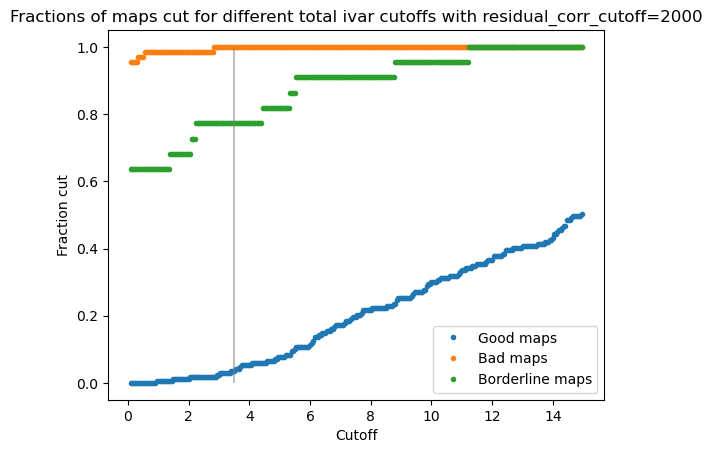

In [186]:
# Same thing with cutoff for residual_sums_corr at 2000
good_fractions_cut = []
bad_fractions_cut = []
border_fractions_cut = []
bad_fits_cut = []
residual_cutoff = 2000
cutoffs = np.arange(0.1,15.0,0.05)
for cutoff in cutoffs:
    in_good = 0
    in_bad = 0
    in_border = 0
    in_bad_fits = 0
    outlier_indices_ivar_sums = np.where(ivar_sums < cutoff)[0]
    outlier_indices_residual_sums = np.where(residual_sums_corr > residual_cutoff)[0]
    #print(outlier_indices_ivar_sums)
    outlier_union = np.union1d(outlier_indices_residual_sums,outlier_indices_ivar_sums)
    num_outlier = len(outlier_union)
    for i in range(num_outlier):
        if outlier_union[i] in all_good: in_good += 1
        elif outlier_union[i] in all_bad: in_bad += 1
        elif outlier_union[i] in borderline: in_border += 1
        elif outlier_union[i] in bad_fits: in_bad_fits += 1
        else: print("index " + str(i) + " not in any list")
    good_fractions_cut.append(in_good/len(all_good))
    bad_fractions_cut.append(in_bad/len(all_bad))
    border_fractions_cut.append(in_border/len(borderline))

bad_fractions_cut = np.array(bad_fractions_cut)
# Finding the index at which all the bad maps are cut
index_all_bad_cut = np.where(bad_fractions_cut == 1.0)[0][0]
print(index_all_bad_cut)
print(cutoffs[index_all_bad_cut])
print("Fraction of good maps cut at index with all bad cut: ", good_fractions_cut[index_all_bad_cut])
print("Fraction borderline cut at index with all bad cut: ", border_fractions_cut[index_all_bad_cut])
    
plt.plot(cutoffs, good_fractions_cut, '.', label="Good maps")
plt.plot(cutoffs, bad_fractions_cut, '.', label="Bad maps")
plt.plot(cutoffs, border_fractions_cut, '.', label="Borderline maps")
plt.vlines(3.5, 0.0, 1.0, colors='gray',alpha=0.5) # Used 3.5 for cut in timestream plot above
plt.legend()
plt.title("Fractions of maps cut for different total ivar cutoffs with residual_corr_cutoff="+str(residual_cutoff))
plt.xlabel("Cutoff")
plt.ylabel("Fraction cut")
plt.show()
plt.close()

In [240]:
# Redoing timestream using these cuts
# residual_sums_corr cutoff at 1500
# ivar cutoff at 1.0
ivar_good = np.where(ivar_sums>1.0)[0]
residual_good = np.where(residual_sums_corr<1500)[0]
all_good_ts = np.intersect1d(np.intersect1d(ivar_good,residual_good),errbar_good)
print("Number of maps that clear all three cuts: ", len(all_good_ts))
timestamps = np.array([int(maps[i].split('_')[1]) for i in all_good_ts])
arrays = np.array([maps[i].split('_')[2] for i in all_good_ts])
angles = np.array([spectra_dict[maps[i]]['meas_angle'] for i in all_good_ts])
errbars = np.array([spectra_dict[maps[i]]['meas_errbar'] for i in all_good_ts])

Number of maps that clear all three cuts:  167


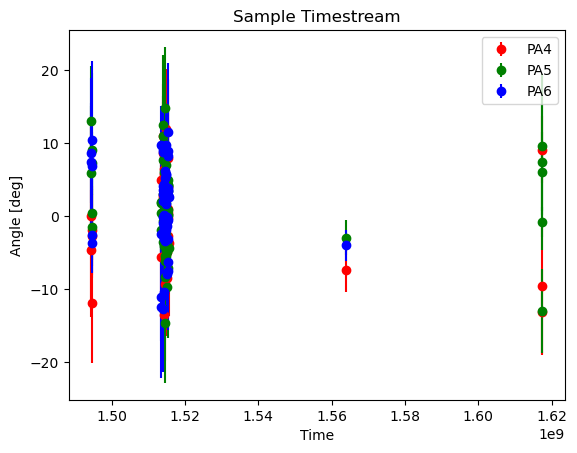

In [201]:
#plt.xticks(rotation=90)
plt.errorbar(timestamps[arrays=='pa4'],angles[arrays=='pa4'],yerr=errbars[arrays=='pa4'],fmt='ro',label="PA4")
plt.errorbar(timestamps[arrays=='pa5'],angles[arrays=='pa5'],yerr=errbars[arrays=='pa5'],fmt='go',label="PA5")
plt.errorbar(timestamps[arrays=='pa6'],angles[arrays=='pa6'],yerr=errbars[arrays=='pa6'],fmt='bo',label="PA6")
plt.legend()
plt.xlabel('Time')
plt.ylabel('Angle [deg]')
plt.title('Sample Timestream')
plt.show()
plt.close()

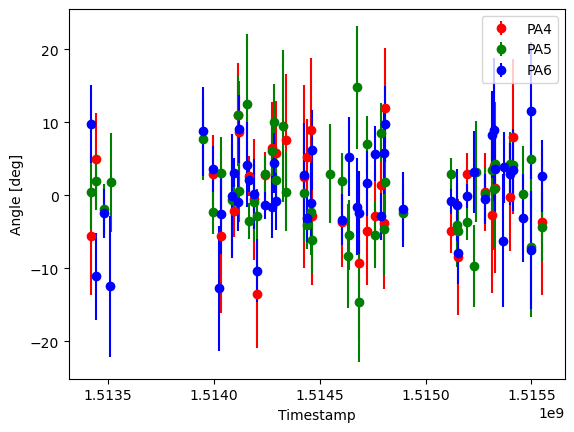

In [224]:
# Code to plot just a specific timestream range based on start and stop timestamp
start_timestamp = 1510000000
stop_timestamp = 1520000000
assert stop_timestamp>start_timestamp, "Stop timestamp must be later than start!"
start_idx = np.where(timestamps > start_timestamp)[0][0]
stop_idx = np.where(timestamps < stop_timestamp)[0][-1] + 1 # plus one ensures slicing doesn't lose last value

pa4_indices = arrays[start_idx:stop_idx]=='pa4'
pa5_indices = arrays[start_idx:stop_idx]=='pa5'
pa6_indices = arrays[start_idx:stop_idx]=='pa6'

#plt.xticks(rotation=90)
plt.errorbar(timestamps[start_idx:stop_idx][pa4_indices],angles[start_idx:stop_idx][pa4_indices],yerr=errbars[start_idx:stop_idx][pa4_indices],fmt='ro',label="PA4")
plt.errorbar(timestamps[start_idx:stop_idx][pa5_indices],angles[start_idx:stop_idx][pa5_indices],yerr=errbars[start_idx:stop_idx][pa5_indices],fmt='go',label="PA5")
plt.errorbar(timestamps[start_idx:stop_idx][pa6_indices],angles[start_idx:stop_idx][pa6_indices],yerr=errbars[start_idx:stop_idx][pa6_indices],fmt='bo',label="PA6")
plt.legend()
plt.xlabel('Timestamp')
plt.ylabel('Angle [deg]')
plt.show()
plt.close()

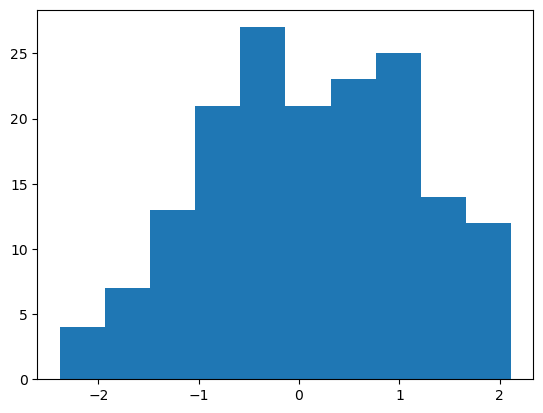

In [241]:
plt.hist(angles/errbars)
plt.show()
plt.close()

In [225]:
# Redoing timestream with my original cuts for comparison
# residual_sums_corr cutoff at 800
# ivar cutoff at 3.5
ivar_good = np.where(ivar_sums>3.5)[0]
residual_good = np.where(residual_sums_corr<800)[0]
all_good_ts = np.intersect1d(np.intersect1d(ivar_good,residual_good),errbar_good)
print("Number of maps that clear all three cuts: ", len(all_good_ts))
timestamps = np.array([int(maps[i].split('_')[1]) for i in all_good_ts])
arrays = np.array([maps[i].split('_')[2] for i in all_good_ts])
angles = np.array([spectra_dict[maps[i]]['meas_angle'] for i in all_good_ts])
errbars = np.array([spectra_dict[maps[i]]['meas_errbar'] for i in all_good_ts])

Number of maps that clear all three cuts:  142


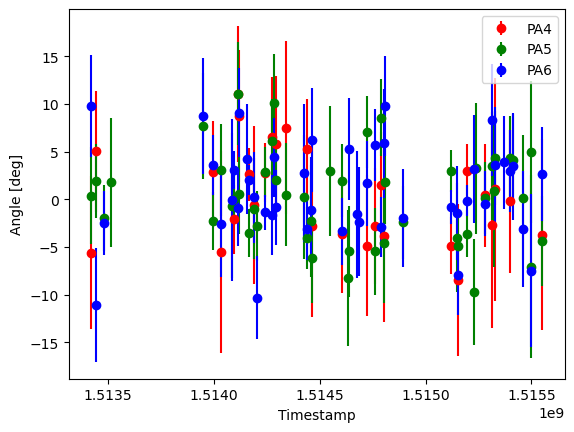

In [226]:
# Code to plot just a specific timestream range based on start and stop timestamp
start_timestamp = 1510000000
stop_timestamp = 1520000000
assert stop_timestamp>start_timestamp, "Stop timestamp must be later than start!"
start_idx = np.where(timestamps > start_timestamp)[0][0]
stop_idx = np.where(timestamps < stop_timestamp)[0][-1] + 1 # plus one ensures slicing doesn't lose last value

pa4_indices = arrays[start_idx:stop_idx]=='pa4'
pa5_indices = arrays[start_idx:stop_idx]=='pa5'
pa6_indices = arrays[start_idx:stop_idx]=='pa6'

#plt.xticks(rotation=90)
plt.errorbar(timestamps[start_idx:stop_idx][pa4_indices],angles[start_idx:stop_idx][pa4_indices],yerr=errbars[start_idx:stop_idx][pa4_indices],fmt='ro',label="PA4")
plt.errorbar(timestamps[start_idx:stop_idx][pa5_indices],angles[start_idx:stop_idx][pa5_indices],yerr=errbars[start_idx:stop_idx][pa5_indices],fmt='go',label="PA5")
plt.errorbar(timestamps[start_idx:stop_idx][pa6_indices],angles[start_idx:stop_idx][pa6_indices],yerr=errbars[start_idx:stop_idx][pa6_indices],fmt='bo',label="PA6")
plt.legend()
plt.xlabel('Timestamp')
plt.ylabel('Angle [deg]')
plt.show()
plt.close()

In [227]:
# Testing one more set of cuts
# residual_sums_corr cutoff at 2000
# ivar cutoff at 3.5
ivar_good = np.where(ivar_sums>3.5)[0]
residual_good = np.where(residual_sums_corr<2000)[0]
all_good_ts = np.intersect1d(np.intersect1d(ivar_good,residual_good),errbar_good)
print("Number of maps that clear all three cuts: ", len(all_good_ts))
timestamps = np.array([int(maps[i].split('_')[1]) for i in all_good_ts])
arrays = np.array([maps[i].split('_')[2] for i in all_good_ts])
angles = np.array([spectra_dict[maps[i]]['meas_angle'] for i in all_good_ts])
errbars = np.array([spectra_dict[maps[i]]['meas_errbar'] for i in all_good_ts])

Number of maps that clear all three cuts:  166


254
1730
Fraction of good maps cut at index with all bad cut:  0.017964071856287425
Fraction borderline cut at index with all bad cut:  0.8181818181818182


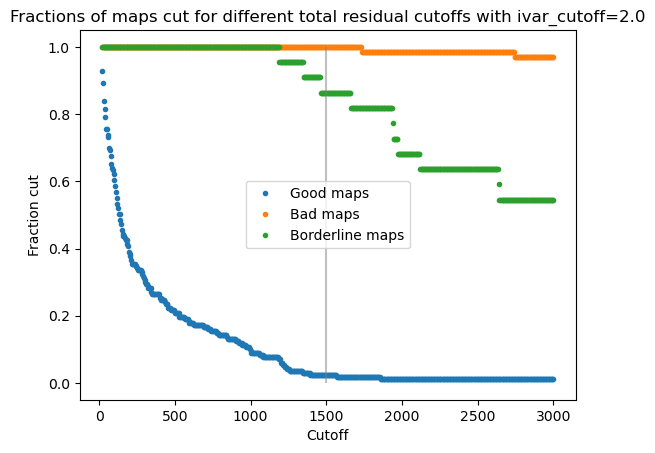

In [238]:
# Testing applying the ivar cut first
good_fractions_cut = []
bad_fractions_cut = []
border_fractions_cut = []
bad_fits_cut = []
ivar_cutoff = 2.0
cutoffs = np.arange(3000,15,-5)
for cutoff in cutoffs:
    in_good = 0
    in_bad = 0
    in_border = 0
    in_bad_fits = 0
    outlier_indices_ivar_sums = np.where(ivar_sums < ivar_cutoff)[0]
    outlier_indices_residual_sums = np.where(residual_sums_corr > cutoff)[0]
    #print(outlier_indices_ivar_sums)
    outlier_union = np.union1d(outlier_indices_residual_sums,outlier_indices_ivar_sums)
    num_outlier = len(outlier_union)
    for i in range(num_outlier):
        if outlier_union[i] in all_good: in_good += 1
        elif outlier_union[i] in all_bad: in_bad += 1
        elif outlier_union[i] in borderline: in_border += 1
        elif outlier_union[i] in bad_fits: in_bad_fits += 1
        else: print("index " + str(i) + " not in any list")
    good_fractions_cut.append(in_good/len(all_good))
    bad_fractions_cut.append(in_bad/len(all_bad))
    border_fractions_cut.append(in_border/len(borderline))

bad_fractions_cut = np.array(bad_fractions_cut)
# Finding the index at which all the bad maps are cut
index_all_bad_cut = np.where(bad_fractions_cut == 1.0)[0][0]
print(index_all_bad_cut)
print(cutoffs[index_all_bad_cut])
print("Fraction of good maps cut at index with all bad cut: ", good_fractions_cut[index_all_bad_cut])
print("Fraction borderline cut at index with all bad cut: ", border_fractions_cut[index_all_bad_cut])
    
plt.plot(cutoffs, good_fractions_cut, '.', label="Good maps")
plt.plot(cutoffs, bad_fractions_cut, '.', label="Bad maps")
plt.plot(cutoffs, border_fractions_cut, '.', label="Borderline maps")
plt.vlines(1500, 0.0, 1.0, colors='gray',alpha=0.5) # Used 1500 for cut in timestream plot above
plt.legend()
plt.title("Fractions of maps cut for different total residual cutoffs with ivar_cutoff="+str(ivar_cutoff))
plt.xlabel("Cutoff")
plt.ylabel("Fraction cut")
plt.show()
plt.close()